In [115]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

In [116]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [117]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [118]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [119]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

In [120]:
def extract_features(model, inputs, style_layers, content_layers):
    inputs = inputs * 255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = model(preprocessed_input)
    style_outputs, content_outputs = (outputs[:len(style_layers)], outputs[len(style_layers):])
    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name: value for content_name, value in zip(content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(style_layers, style_outputs)}
    return {'content': content_dict, 'style': style_dict}

In [121]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    return style_loss + content_loss

In [122]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [123]:
@tf.function()
def train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, total_variation_weight, num_style_layers, num_content_layers, style_layers, content_layers):
    with tf.GradientTape() as tape:
        outputs = extract_features(extractor, image, style_layers, content_layers)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight, num_style_layers, num_content_layers)
        loss += total_variation_weight * tf.image.total_variation(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [124]:
def run_style_transfer(content_path, style_path, lr=0.02, beta1=0.99, epsilon=1e-1, style_weight=1e-2, content_weight=1e4, tv_weight=30, iterations=500, checkpoint_iterations=100):
    content_image = load_img(content_path)
    style_image = load_img(style_path)
    opt = tf.optimizers.Adam(learning_rate=lr, beta_1=beta1, epsilon=epsilon)

    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    num_content_layers = len(content_layers)
    num_style_layers = len(style_layers)

    extractor = vgg_layers(style_layers + content_layers)
    style_targets = extract_features(extractor, style_image, style_layers, content_layers)['style']
    content_targets = extract_features(extractor, content_image, style_layers, content_layers)['content']
    image = tf.Variable(content_image)

    epochs = 10
    steps_per_epoch = iterations
    step = 0

    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image, extractor, style_targets, content_targets, opt, style_weight, content_weight, tv_weight, num_style_layers, num_content_layers, style_layers, content_layers)
        if (step % checkpoint_iterations == 0):
            print('Iteration: {}'.format(step))
            tensor_to_image(image).save(f"output_{step}_iter.png")

    file_name = 'stylized-image.png'
    tensor_to_image(image).save(file_name)
    return image



Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50


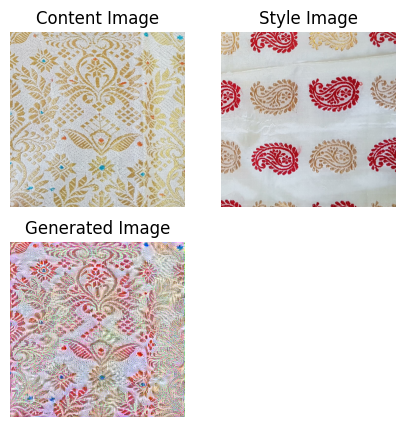

In [125]:
def display_images(content_path, style_path, generated_image):
    content_image = load_img(content_path)
    style_image = load_img(style_path)

    content_image = tensor_to_image(content_image)
    style_image = tensor_to_image(style_image)
    generated_image = tensor_to_image(generated_image)

    fig, axs = plt.subplots(2, 2, figsize=(5, 5))

    axs[0, 0].imshow(content_image)
    axs[0, 0].set_title('Content Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(style_image)
    axs[0, 1].set_title('Style Image')
    axs[0, 1].axis('off')

    axs[1, 0].imshow(generated_image)
    axs[1, 0].set_title('Generated Image')
    axs[1, 0].axis('off')

    axs[1, 1].axis('off')

    plt.show()


content_path = 'img11.jpg'
style_path = 'img12.jpg'
# output_path = 'path_to_output_directory'

generated_image = run_style_transfer(
    content_path=content_path,
    style_path=style_path,
    lr=0.02,
    beta1=0.99,
    epsilon=1e-1,
    style_weight=1e-2,
    content_weight=1e4,
    tv_weight=30,
    iterations=5,
    checkpoint_iterations=10
)

display_images(content_path, style_path, generated_image)
